In [40]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
pwd = os.getcwd()
print(pwd)

e:\research\HEA_phase_classification\weighted_features\classification\new_alloy\model_training


In [42]:
alloy_data = pd.read_excel(pwd + "/new_alloys_and_predicted_phases.xlsx")
alloy_data .head()

,HEA_formula,predicted_phases,Base_element
0,VZr0.12Cr0.12W0.25Hf,S,V
1,VZr0.12Cr0.12W0.38Hf0.88,S,V
2,VZr0.12Cr0.12W0.5Hf0.75,S,V
3,VZr0.12Cr0.12W0.62Hf0.62,S,V
4,VZr0.12Cr0.12W0.75Hf0.5,S,V


In [43]:
import re

def extract_percentages(formula):
    """Extract elemental percentages from the given formula."""
    elements = re.findall(r'([A-Z][a-z]?)([\d\.]*)', formula)
    return {element: float(percentage) if percentage else 1.0 for element, percentage in elements}

# Extract percentages for each row and store in a new dataframe
percentages_df = alloy_data['HEA_formula'].apply(extract_percentages).apply(pd.Series)

# Merge with original dataframe
alloy_data_expanded = pd.concat([alloy_data, percentages_df], axis=1)

alloy_data_expanded.head()

,HEA_formula,predicted_phases,Base_element,V,Zr,Cr,W,Hf,Co,Mo,Ti,Nb,Ta,Al
0,VZr0.12Cr0.12W0.25Hf,S,V,1.0,0.12,0.12,0.25,1.00,NaN,NaN,NaN,NaN,NaN,NaN
1,VZr0.12Cr0.12W0.38Hf0.88,S,V,1.0,0.12,0.12,0.38,0.88,NaN,NaN,NaN,NaN,NaN,NaN
2,VZr0.12Cr0.12W0.5Hf0.75,S,V,1.0,0.12,0.12,0.50,0.75,NaN,NaN,NaN,NaN,NaN,NaN
3,VZr0.12Cr0.12W0.62Hf0.62,S,V,1.0,0.12,0.12,0.62,0.62,NaN,NaN,NaN,NaN,NaN,NaN
4,VZr0.12Cr0.12W0.75Hf0.5,S,V,1.0,0.12,0.12,0.75,0.50,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# Filter based on the unique base elements
base_elements = alloy_data_expanded['Base_element'].unique()

# Split the dataframe based on predicted phases
single_phase_df = alloy_data_expanded[alloy_data_expanded['predicted_phases'] == 'S']
multi_phase_df = alloy_data_expanded[alloy_data_expanded['predicted_phases'] == 'M']

In [45]:
# Create an empty dataframe to store the mean percentage differences for each base element
mean_percentages_df = pd.DataFrame()

# Iterate over each base element to compute mean differences
for base_element in base_elements:
    single_phase_subset = single_phase_df[single_phase_df['Base_element'] == base_element]
    multi_phase_subset = multi_phase_df[multi_phase_df['Base_element'] == base_element]

    single_phase_means = single_phase_subset.iloc[:, 3:].mean()
    multi_phase_means = multi_phase_subset.iloc[:, 3:].mean()

    mean_difference = single_phase_means - multi_phase_means

    mean_percentages_df[base_element] = mean_difference

# Transpose the dataframe for plotting
mean_percentages_df = mean_percentages_df.transpose()

# Sort the base elements
sorted_base_elements = sorted(base_elements)

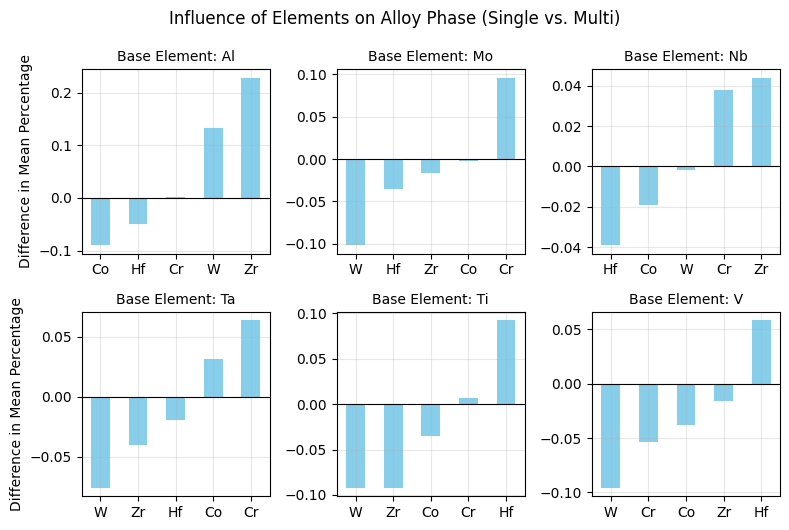

In [46]:
mean_percentages_df = pd.DataFrame()
for base_element in sorted_base_elements:
    single_phase_subset = single_phase_df[single_phase_df['Base_element'] == base_element]
    multi_phase_subset = multi_phase_df[multi_phase_df['Base_element'] == base_element]

    single_phase_means = single_phase_subset.iloc[:, 3:].mean()
    multi_phase_means = multi_phase_subset.iloc[:, 3:].mean()

    mean_difference = single_phase_means - multi_phase_means
    mean_percentages_df[base_element] = mean_difference

mean_percentages_df = mean_percentages_df.transpose()

# Generate the plots
plt.figure(figsize=(8, 5))
for i, base_element in enumerate(sorted_base_elements, 1):
    if base_element in mean_percentages_df.index:
        plt.subplot(2, 3, i)
        mean_percentages_df.loc[base_element].drop(base_element).dropna().sort_values().plot(kind='bar', color='skyblue')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.title(f'Base Element: {base_element}', fontsize=10)
        
        # Show the label only for the 1st and 4th subplot
        if i in [1, 4]:
            plt.ylabel('Difference in Mean Percentage', fontsize=10)
        else:
            plt.ylabel('')  # This line ensures that the ylabel is cleared for other subplots
        
        plt.grid(alpha=0.3)
        plt.xticks(rotation=0)
        plt.tight_layout()

plt.suptitle('Influence of Elements on Alloy Phase (Single vs. Multi)', y=1.05, fontsize=12)
plt.savefig(pwd + "/mean_percentage_analysis.png", dpi=1000, bbox_inches='tight')
plt.show()

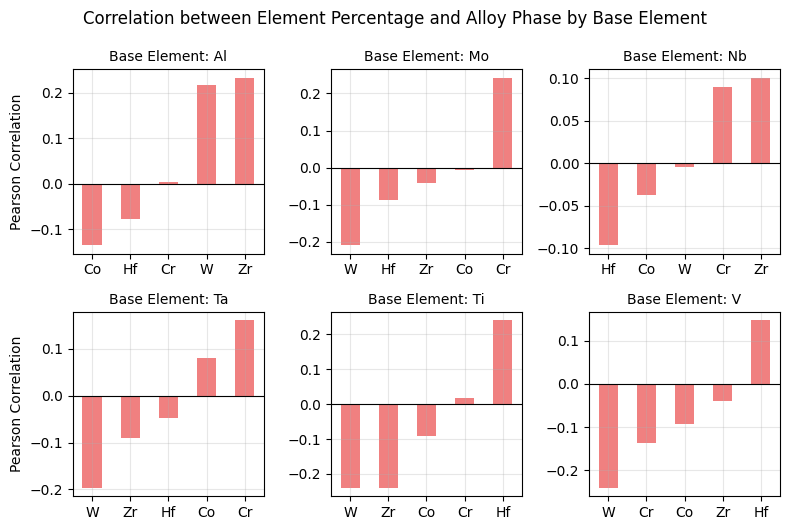

In [47]:
# Encoding the predicted_phases column
alloy_data_expanded['predicted_phases_numeric'] = alloy_data_expanded['predicted_phases'].map({'S': 1, 'M': 0})

# Calculate the Pearson correlation between each element's percentage and the encoded phase
correlation_df = alloy_data_expanded.iloc[:, 3:-1].apply(lambda x: x.corr(alloy_data_expanded['predicted_phases_numeric']))


# Create an empty dataframe to store the correlation values for each base element
correlation_by_base_element_df = pd.DataFrame()

# Iterate over each base element to compute correlation values
for base_element in sorted_base_elements:
    subset = alloy_data_expanded[alloy_data_expanded['Base_element'] == base_element]
    correlations = subset.iloc[:, 3:-1].apply(lambda x: x.corr(subset['predicted_phases_numeric']))
    correlation_by_base_element_df[base_element] = correlations

# Transpose the dataframe for plotting
correlation_by_base_element_df = correlation_by_base_element_df.transpose()

# Plotting the correlation values for each base element
plt.figure(figsize=(8, 5))

# Iterate over each sorted base element to create bar plots
for i, base_element in enumerate(correlation_by_base_element_df.index, 1):
    plt.subplot(2, 3, i)
    correlation_by_base_element_df.loc[base_element].dropna().sort_values().plot(kind='bar', color='lightcoral')
    plt.axhline(0, color='black', linewidth=0.8)  # Line to indicate zero
    plt.title(f'Base Element: {base_element}', fontsize=10)
    
    # Show the label only for the 1st and 4th subplot
    if i in [1, 4]:
        plt.ylabel('Pearson Correlation', fontsize=10)
    else:
        plt.ylabel('')  # This line ensures that the ylabel is cleared for other subplots

    #plt.ylim(-0.3, 0.3)
    plt.xticks(rotation=0)
    plt.grid(alpha=0.3)
    plt.tight_layout()

plt.suptitle('Correlation between Element Percentage and Alloy Phase by Base Element', y=1.05, fontsize=12)
plt.savefig(pwd + "/correlation_analysis.png", dpi=1000, bbox_inches='tight')
plt.show()

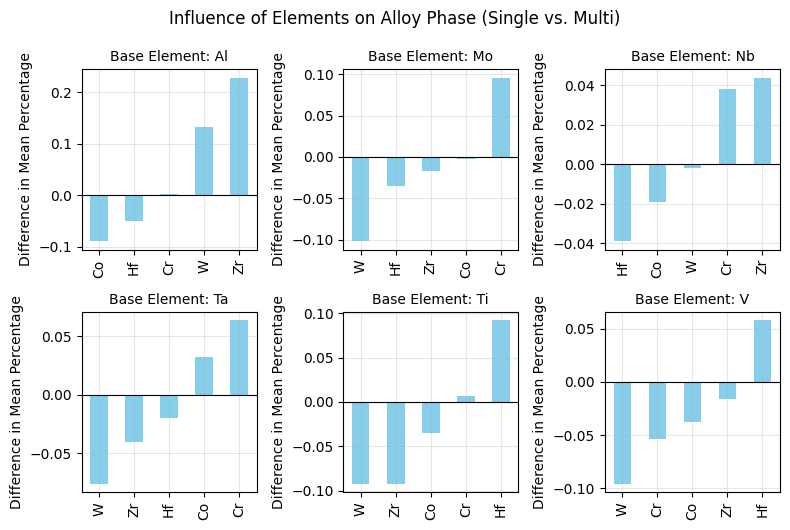

In [48]:
mean_percentages_df = pd.DataFrame()
for base_element in sorted_base_elements:
    single_phase_subset = single_phase_df[single_phase_df['Base_element'] == base_element]
    multi_phase_subset = multi_phase_df[multi_phase_df['Base_element'] == base_element]

    single_phase_means = single_phase_subset.iloc[:, 3:].mean()
    multi_phase_means = multi_phase_subset.iloc[:, 3:].mean()

    mean_difference = single_phase_means - multi_phase_means
    mean_percentages_df[base_element] = mean_difference

mean_percentages_df = mean_percentages_df.transpose()

# Generate the plots
plt.figure(figsize=(8, 5))
for i, base_element in enumerate(sorted_base_elements, 1):
    if base_element in mean_percentages_df.index:
        plt.subplot(2, 3, i)
        mean_percentages_df.loc[base_element].drop(base_element).dropna().sort_values().plot(kind='bar', color='skyblue')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.title(f'Base Element: {base_element}', fontsize=10)
        plt.ylabel('Difference in Mean Percentage', fontsize=10)
        plt.grid(alpha=0.3)
        plt.tight_layout()

plt.suptitle('Influence of Elements on Alloy Phase (Single vs. Multi)', y=1.05, fontsize=12)
plt.show()

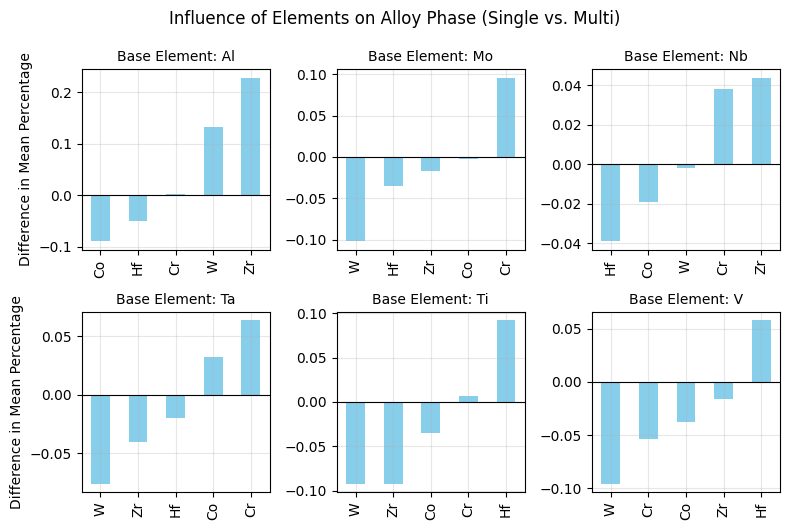

In [49]:
mean_percentages_df = pd.DataFrame()
for base_element in sorted_base_elements:
    single_phase_subset = single_phase_df[single_phase_df['Base_element'] == base_element]
    multi_phase_subset = multi_phase_df[multi_phase_df['Base_element'] == base_element]

    single_phase_means = single_phase_subset.iloc[:, 3:].mean()
    multi_phase_means = multi_phase_subset.iloc[:, 3:].mean()

    mean_difference = single_phase_means - multi_phase_means
    mean_percentages_df[base_element] = mean_difference

mean_percentages_df = mean_percentages_df.transpose()

# Generate the plots
plt.figure(figsize=(8, 5))
for i, base_element in enumerate(sorted_base_elements, 1):
    if base_element in mean_percentages_df.index:
        plt.subplot(2, 3, i)
        mean_percentages_df.loc[base_element].drop(base_element).dropna().sort_values().plot(kind='bar', color='skyblue')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.title(f'Base Element: {base_element}', fontsize=10)
        
        # Show the label only for the 1st and 4th subplot
        if i in [1, 4]:
            plt.ylabel('Difference in Mean Percentage', fontsize=10)
        else:
            plt.ylabel('')  # This line ensures that the ylabel is cleared for other subplots
        
        plt.grid(alpha=0.3)
        plt.tight_layout()

plt.suptitle('Influence of Elements on Alloy Phase (Single vs. Multi)', y=1.05, fontsize=12)
plt.show()

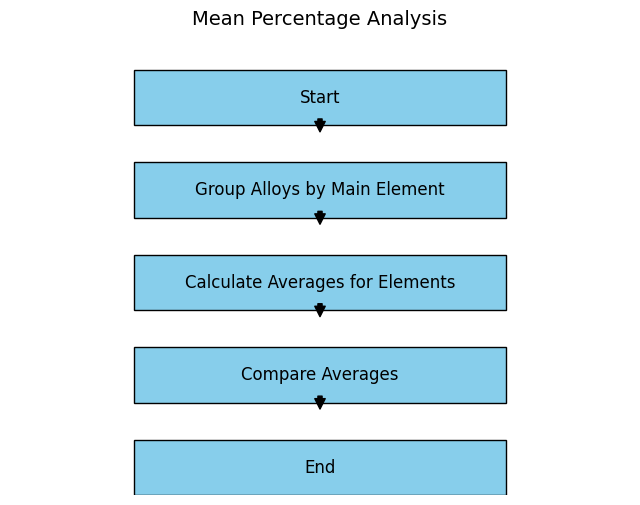

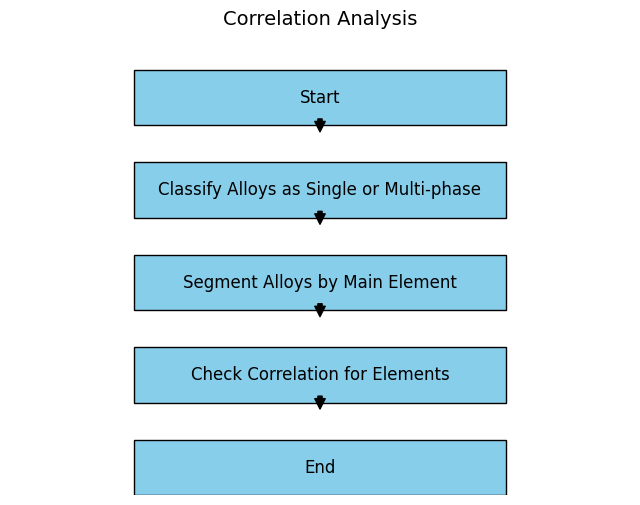

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_flowchart(steps, title):
    fig, ax = plt.subplots(figsize=(8, len(steps)*1.2))
    ax.axis('off')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(steps))
    
    # Create the boxes
    for i, step in enumerate(steps):
        rect = mpatches.Rectangle((2, len(steps)-i-1), 6, 0.6, ec="k", fc="skyblue")
        ax.add_patch(rect)
        ax.text(5, len(steps)-i-0.7, step, ha='center', va='center', fontsize=12)
        
    # Create the arrows
    for i in range(len(steps)-1):
        arrow = mpatches.FancyArrowPatch((5, len(steps)-i-0.9), (5, len(steps)-i-1.1),
                                         mutation_scale=15, fc="k")
        ax.add_patch(arrow)
    
    ax.set_title(title, fontsize=14)
    plt.show()

# Steps for the two methods
mean_percentage_steps = ["Start", "Group Alloys by Main Element", "Calculate Averages for Elements", 
                         "Compare Averages", "End"]
correlation_analysis_steps = ["Start", "Classify Alloys as Single or Multi-phase", 
                              "Segment Alloys by Main Element", "Check Correlation for Elements", "End"]

# Plot the flowcharts
plot_flowchart(mean_percentage_steps, "Mean Percentage Analysis")
plot_flowchart(correlation_analysis_steps, "Correlation Analysis")

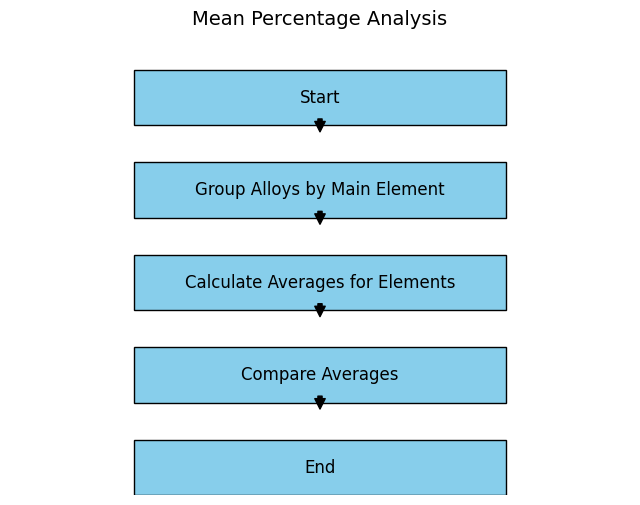

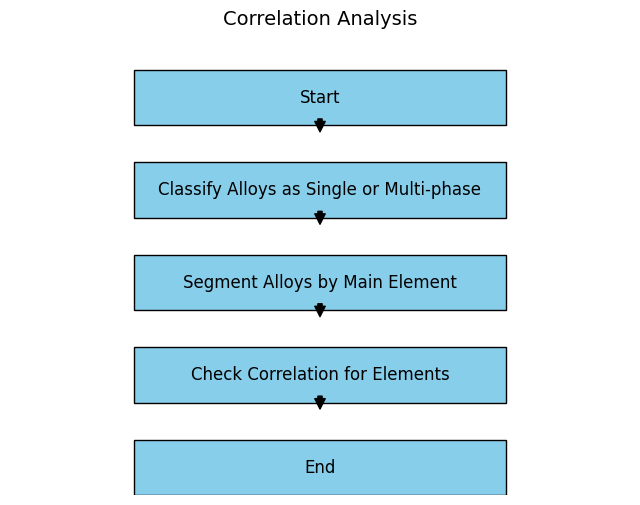

In [2]:
# Attempting to generate the flowcharts again

def plot_flowchart(steps, title):
    fig, ax = plt.subplots(figsize=(8, len(steps)*1.2))
    ax.axis('off')
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(steps))
    
    # Create the boxes
    for i, step in enumerate(steps):
        rect = mpatches.Rectangle((2, len(steps)-i-1), 6, 0.6, ec="k", fc="skyblue")
        ax.add_patch(rect)
        ax.text(5, len(steps)-i-0.7, step, ha='center', va='center', fontsize=12)
        
    # Create the arrows
    for i in range(len(steps)-1):
        arrow = mpatches.FancyArrowPatch((5, len(steps)-i-0.9), (5, len(steps)-i-1.1),
                                         mutation_scale=15, fc="k")
        ax.add_patch(arrow)
    
    ax.set_title(title, fontsize=14)
    plt.show()

# Plot the flowcharts
plot_flowchart(mean_percentage_steps, "Mean Percentage Analysis")
plot_flowchart(correlation_analysis_steps, "Correlation Analysis")